# Let's first know about the Competition

## About the Data

The dataset contains argumentative essays written by U.S students in grades 6-12. The essays were annotated by expert raters for elements commonly found in argumentative writing. hese essays were annotated by expert raters for discourse elements commonly found in argumentative writing:
 - **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis.
 - **Position** - an opinion or conclusion on the main question.
 - **Claim** - a claim that supports the position.
 - **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position.
 - **Rebuttal** - a claim that refutes a counterclaim.
 - **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
 - **Concluding Statement** - a concluding statement that restates the claims.

## Goal of the Competition

The goal of this competition is to classify argumentative elements in student writing as 
  - **effective**
  - **adequate**
  - **ineffective**

## Training Data
The training set consist of a *.csv* file containing the annotated discourse elements each essay, including the quality ratings, together with *.txt* files containing the full text of each essay. It is important to note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above) and they will lack a quality rating. We do not include the unannotated parts in train.csv.

 - **train.csv** - Contains the annotated discourse elements for all essays in the test set.
 - **discourse_id** - ID code for discourse element.
 - **essay_id** - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.
 - **discourse_text** - Text of discourse element.
 - **discourse_type** - Class label of discourse element.
 - **discourse_effectiveness** - Quality rating of discourse element, the target.

**Definitions and Examples of Argumentation Elements**

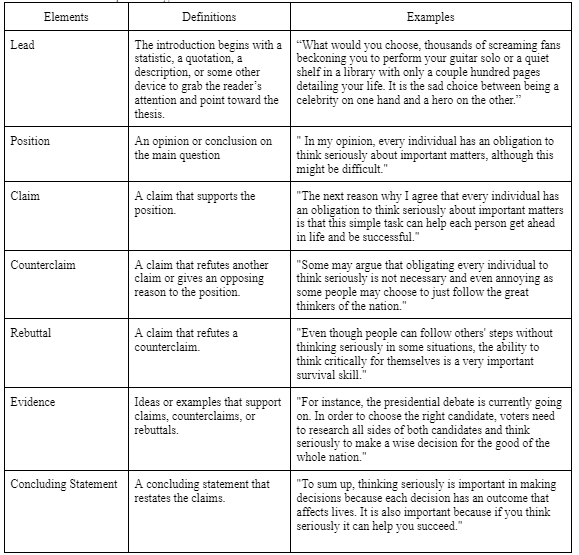

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import spacy
from spacy import displacy
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

import en_core_web_sm
nlp = en_core_web_sm.load()

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

In [ ]:
df = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')
print(f'The training set has {df.shape[0]} rows and {df.shape[1]} columns')

### Concise summary of the DataFrame

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
print(f"We have {df['essay_id'].nunique()} essays")

## Let's do some visuals

In [ ]:
df['full_text'] = df['discourse_text'].groupby(df['essay_id']).transform(lambda x: ' '.join(x))

Let's view a random example text..

In [ ]:
pos = random.randint(0, (df['essay_id'].nunique() - 1))
df.full_text.iloc[pos]

### Text Length

In [ ]:
fig = plt.figure(figsize=(10,8)) # set the figure size
text_length = df['full_text'].drop_duplicates().apply(len)
text_length.plot(kind='hist', color = "lightblue", bins=100)
plt.title('Essay Length Distribution')
plt.xlabel("Essay Length")
plt.ylabel("Frequency");

### Word Count

In [ ]:
fig = plt.figure(figsize=(10,8))
word_count = df['full_text'].drop_duplicates().apply(lambda x: len(str(x).split()))

ax1 = word_count.plot(kind='hist', color = "lightgreen", bins=100)
ax1.set_title('Word Count Distribution')
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Frequency");

# N-gram

In [ ]:
def get_top_n_words(corpus, n=None, remove_stop_words=False, n_words=1): # if n_words=1 -> unigrams, if n_words=2 -> bigrams..
    if remove_stop_words:
        vec = CountVectorizer(stop_words = 'english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Unigram

In [ ]:
unigram_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=1)
for word, freq in unigram_words:
    print(word, freq)

In [ ]:
fig = plt.figure(figsize=(10,8))
uni_df_tmp = pd.DataFrame(unigram_words, columns = ['text' , 'count'])
ax1 = uni_df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = "coral")
ax1.set_title('Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency");

## Bigram

In [ ]:
bigram_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in bigram_words:
    print(word, freq)

In [ ]:
fig = plt.figure(figsize=(10,8))
bi_df_tmp = pd.DataFrame(bigram_words, columns = ['text' , 'count'])
ax1 = bi_df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = "coral")
ax1.set_title('Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency");

## Trigram

In [ ]:
trigram_words = get_top_n_words(df['full_text'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in trigram_words:
    print(word, freq)

In [ ]:
fig = plt.figure(figsize=(10,8))
tri_df_tmp = pd.DataFrame(trigram_words, columns = ['text' , 'count'])
ax1 = tri_df_tmp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', color = "coral")
ax1.set_title('Trigram Distribution')
ax1.set_xlabel("Trigrams")
ax1.set_ylabel("Frequency");

# Distribution of top n-grams for each discourse type

## Unigram

In [ ]:
text_Lead = df[df.discourse_type == 'Lead'].discourse_text.values
text_Position = df[df.discourse_type == 'Position'].discourse_text.values
text_Evidence = df[df.discourse_type == 'Evidence'].discourse_text.values
text_Claim = df[df.discourse_type == 'Claim'].discourse_text.values
text_Concluding_Statement = df[df.discourse_type == 'Concluding Statement'].discourse_text.values
text_Counterclaim = df[df.discourse_type == 'Counterclaim'].discourse_text.values
text_Rebuttal = df[df.discourse_type == 'Rebuttal'].discourse_text.values

common_words_Lead = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=1)
common_words_Position = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=1)
common_words_Evidence = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=1)
common_words_Claim = get_top_n_words(text_Claim, 20, remove_stop_words=True, n_words=1)
common_words_Concluding_Statement = get_top_n_words(text_Concluding_Statement, 20, remove_stop_words=True, n_words=1)
common_words_Counterclaim = get_top_n_words(text_Counterclaim, 20, remove_stop_words=True, n_words=1)
common_words_Rebuttal = get_top_n_words(text_Rebuttal, 20, remove_stop_words=True, n_words=1)



df_tmp_Lead = pd.DataFrame(common_words_Lead, columns = ['text' , 'count'])
df_tmp_Position = pd.DataFrame(common_words_Position, columns = ['text' , 'count'])
df_tmp_Evidence = pd.DataFrame(common_words_Evidence, columns = ['text' , 'count'])
df_tmp_Claim = pd.DataFrame(common_words_Claim, columns = ['text' , 'count'])
df_tmp_Concluding_Statement = pd.DataFrame(common_words_Concluding_Statement, columns = ['text' , 'count'])
df_tmp_Counterclaim = pd.DataFrame(common_words_Counterclaim, columns = ['text' , 'count'])
df_tmp_Rebuttal = pd.DataFrame(common_words_Rebuttal, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Lead.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "olive")
ax1.set_title('Lead Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Position.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "olive")
ax2.set_title('Position Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Evidence.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "olive")
ax1.set_title('Evidence Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Claim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "olive")
ax2.set_title('Claim Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Concluding_Statement.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "olive")
ax1.set_title('Concluding Statement Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Counterclaim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "olive")
ax2.set_title('Counterclaim Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Rebuttal.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "olive")
ax1.set_title('Rebuttal Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency");

## Bigram

In [ ]:
common_words_Lead = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=2)
common_words_Position = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=2)
common_words_Evidence = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=2)
common_words_Claim = get_top_n_words(text_Claim, 20, remove_stop_words=True, n_words=2)
common_words_Concluding_Statement = get_top_n_words(text_Concluding_Statement, 20, remove_stop_words=True, n_words=2)
common_words_Counterclaim = get_top_n_words(text_Counterclaim, 20, remove_stop_words=True, n_words=2)
common_words_Rebuttal = get_top_n_words(text_Rebuttal, 20, remove_stop_words=True, n_words=2)



df_tmp_Lead = pd.DataFrame(common_words_Lead, columns = ['text' , 'count'])
df_tmp_Position = pd.DataFrame(common_words_Position, columns = ['text' , 'count'])
df_tmp_Evidence = pd.DataFrame(common_words_Evidence, columns = ['text' , 'count'])
df_tmp_Claim = pd.DataFrame(common_words_Claim, columns = ['text' , 'count'])
df_tmp_Concluding_Statement = pd.DataFrame(common_words_Concluding_Statement, columns = ['text' , 'count'])
df_tmp_Counterclaim = pd.DataFrame(common_words_Counterclaim, columns = ['text' , 'count'])
df_tmp_Rebuttal = pd.DataFrame(common_words_Rebuttal, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Lead.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "magenta")
ax1.set_title('Lead Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Position.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "magenta")
ax2.set_title('Position Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Evidence.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "magenta")
ax1.set_title('Evidence Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Claim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "magenta")
ax2.set_title('Claim Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Concluding_Statement.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "magenta")
ax1.set_title('Concluding Statement Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Counterclaim.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "magenta")
ax2.set_title('Counterclaim Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Rebuttal.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "magenta")
ax1.set_title('Rebuttal Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency");

# Distribution of top n-grams for each discourse effectiveness

## Unigram

In [ ]:
text_Effective = df[df.discourse_effectiveness == 'Effective'].discourse_text.values
text_Adequate = df[df.discourse_effectiveness == 'Adequate'].discourse_text.values
text_Ineffective = df[df.discourse_effectiveness == 'Ineffective'].discourse_text.values

common_words_Effective = get_top_n_words(text_Effective, 20, remove_stop_words=True, n_words=1)
common_words_Adequate = get_top_n_words(text_Adequate, 20, remove_stop_words=True, n_words=1)
common_words_Ineffective = get_top_n_words(text_Ineffective, 20, remove_stop_words=True, n_words=1)

df_tmp_Effective = pd.DataFrame(common_words_Effective, columns = ['text' , 'count'])
df_tmp_Adequate = pd.DataFrame(common_words_Adequate, columns = ['text' , 'count'])
df_tmp_Ineffective = pd.DataFrame(common_words_Ineffective, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Effective.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "salmon")
ax1.set_title('Effective Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Adequate.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "salmon")
ax2.set_title('Adequate Unigram Distribution')
ax2.set_xlabel("Unigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Ineffective.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "salmon")
ax1.set_title('Ineffective Unigram Distribution')
ax1.set_xlabel("Unigrams")
ax1.set_ylabel("Frequency");

## Bigram

In [ ]:
common_words_Effective = get_top_n_words(text_Lead, 20, remove_stop_words=True, n_words=2)
common_words_Adequate = get_top_n_words(text_Position, 20, remove_stop_words=True, n_words=2)
common_words_Ineffective = get_top_n_words(text_Evidence, 20, remove_stop_words=True, n_words=2)


df_tmp_Effective = pd.DataFrame(common_words_Effective, columns = ['text' , 'count'])
df_tmp_Adequate = pd.DataFrame(common_words_Adequate, columns = ['text' , 'count'])
df_tmp_Ineffective = pd.DataFrame(common_words_Ineffective, columns = ['text' , 'count'])

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Effective.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "navy")
ax1.set_title('Effective Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(122)
ax2 = df_tmp_Adequate.groupby('text').sum()['count'].sort_values(ascending=False).plot(
   kind='bar', color = "navy")
ax2.set_title('Adequate Bigram Distribution')
ax2.set_xlabel("Bigrams")
ax2.set_ylabel("Frequency")

fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1 = df_tmp_Ineffective.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', color = "navy")
ax1.set_title('Ineffective Bigram Distribution')
ax1.set_xlabel("Bigrams")
ax1.set_ylabel("Frequency");

# Text Distribution

### Discourse type

In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = df['discourse_type'].value_counts().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Part of Text for Each Essay')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency")

### Discourse Effectiveness

In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = df['discourse_effectiveness'].value_counts().plot(kind='bar', color = '#120f7a')
ax1.set_title('Distribution of Different Part of Text for Each Essay')
ax1.set_xlabel("")
ax1.set_ylabel("Frequency");

In [ ]:
def color_func(word, font_size, position, orientation, random_state=None, hsl=[242, 70, 20],
                    **kwargs):
    return f"hsl({hsl[0]}, {random.randint(hsl[1]-10, hsl[1]+10)}%, {random.randint(hsl[2]-10, hsl[1]+10)}%)"

# Word Clouds

### Discourse type

In [ ]:
wc_text_Lead = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Position = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Evidence = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Claim = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Concluding_Statement = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Counterclaim = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Rebuttal = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))


wc_text_Lead.generate(" ".join(text_Lead))
wc_text_Position.generate(" ".join(text_Position))
wc_text_Evidence.generate(" ".join(text_Evidence))
wc_text_Claim.generate(" ".join(text_Claim))
wc_text_Concluding_Statement.generate(" ".join(text_Concluding_Statement))
wc_text_Counterclaim.generate(" ".join(text_Counterclaim))
wc_text_Rebuttal.generate(" ".join(text_Rebuttal))


fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Lead.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Lead", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Position.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Position", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Evidence.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Evidence", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Claim.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Claim", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Concluding_Statement.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Concluding Statement", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Counterclaim.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Counterclaim", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Rebuttal.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Concluding Rebuttal", fontsize=20)

plt.show()


### Discourse Effectiveness

In [ ]:
wc_text_Effective = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Adequate = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))
wc_text_Ineffective = WordCloud(background_color="#fff",max_words=1000,stopwords=set(STOPWORDS))


wc_text_Effective.generate(" ".join(text_Effective))
wc_text_Adequate.generate(" ".join(text_Adequate))
wc_text_Ineffective.generate(" ".join(text_Ineffective))

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Effective.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Effective", fontsize=20)

ax2 = fig.add_subplot(122)
ax2 = plt.imshow(wc_text_Adequate.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax2 = plt.title("Adequate", fontsize=20)

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
ax1 = plt.imshow(wc_text_Ineffective.recolor(color_func=color_func, random_state=42),
           interpolation="bilinear")
ax1 = plt.title("Ineffective", fontsize=20)


### Please consider Upvotting, if you find it useful.